# Comp551 Mini-Project 2 - Sentiment Dataset

# **1. Acquire, preprocess, and analyze the data**

In [4]:
import pandas as pd
import numpy as np
# Set the seed for reproducibility (initializes the random number generator)
np.random.seed(500)

### **1.1 Prep work: Downloading necessary files and remove unneeded columns**


#### **1.1.1 Download and import data**

Before we get started, we need to download all of the data we'll be using.
* **training.1600000.processed.noemoticon.csv:** raw data from Sentiment140 - 1.6[link text](https:// [link text](https://)) million tweets tagged for sentiment, no column headers, nothing cleaned up

In [5]:
!mkdir -p data
!wget -nc http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip -P data
!unzip -n -d data data/trainingandtestdata.zip

sentiment_train = pd.read_csv("data/training.1600000.processed.noemoticon.csv",
                names=['polarity', 'id', 'date', 'query', 'user', 'text'],
                encoding='latin-1')

sentiment_test = pd.read_csv("data/testdata.manual.2009.06.14.csv",
                names=['polarity', 'id', 'date', 'query', 'user', 'text'],
                encoding='latin-1')

--2022-03-09 16:53:32--  http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip [following]
--2022-03-09 16:53:32--  https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81363704 (78M) [application/zip]
Saving to: ‘data/trainingandtestdata.zip’

trainingandtestdata 100%[===================>]  77.59M  20.8MB/s    in 4.5s    

2022-03-09 16:53:37 (17.1 MB/s) - ‘data/trainingandtestdata.zip’ saved [81363704/81363704]

Archive:  data/trainingandtestdata.zip
  inflating: data/testdata.manual.2009.06.14.csv  
  inflating: data/training.1600000.processed.noemoticon.csv  


In [6]:
sentiment_test.head()

,polarity,id,date,query,user,text
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...


#### **1.1.2 Update polarity column**

In [7]:
sentiment_test[sentiment_test['polarity']==2].shape[0]

139

Right now the `polarity` column is `0` for negative, `4` for positive. Let's change that to `0` and `1` to make things a little more reasonably readable.

In [8]:
sentiment_train.polarity = sentiment_train.polarity.replace({0: 0, 4: 1})
print("TRAIN: Sentiment140 polarity count")
sentiment_train.polarity.value_counts()

TRAIN: Sentiment140 polarity count


0    800000
1    800000
Name: polarity, dtype: int64

In [9]:
# Drop the columns with neutral
sentiment_test = sentiment_test.drop(sentiment_test[sentiment_test.polarity == 2].index)
sentiment_test.polarity = sentiment_test.polarity.replace({0: 0, 4: 1})
print("TEST: Sentiment140 polarity count")
sentiment_test.polarity.value_counts()

TEST: Sentiment140 polarity count


1    182
0    177
Name: polarity, dtype: int64

#### **1.1.3 Remove unneeded columns**

We don't need all those columns! Let's get rid of the ones that won't affect the sentiment.

In [10]:
sentiment_train = sentiment_train.drop(columns=['id', 'date', 'query', 'user'])
sentiment_train.rename(columns = {'polarity' : 'label'}, inplace = True)

In [11]:
sentiment_test = sentiment_test.drop(columns=['id', 'date', 'query', 'user'])
sentiment_test.rename(columns = {'polarity' : 'label'}, inplace = True)

#### **1.1.4 Sample tweets**

To make the size of the file smaller to incease execution time, we sample only 500,000 tweets.

Now we have a dataframe with 500,000 tweets where we labelled the positive and negative tweets as 1 and 0 respectively.

In [12]:
sentiment_train = sentiment_train.sample(n=20000)

# Liyun - size of the test is smaller than 500,000
#sentiment_test = sentiment_test.sample(n=500000)

### **1.2 Data Preprocessing**

#### **1.2.1 Import relevant packages**

In [13]:
from nltk import pos_tag, word_tokenize          
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
import nltk
import seaborn as sns
import matplotlib.pyplot as plt

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [14]:
tokenizer = RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
stop_words = stopwords.words('english')

#### **1.2.2 Begin preprocessing data**

In [15]:
import re
import string

# Lemmatize and Tokenize
def lemmatize_text(text):
    return ' '.join([lemmatizer.lemmatize(word) for word in tokenizer.tokenize(text.lower())])

# Remove stopwords
def remove_stopwords(text):
  return ' '.join([word for word in text.split() if word not in (stop_words)])

# Remove numbers
alphanumeric = lambda x: re.sub(r"""\w*\d\w*""", ' ', x)
strip = lambda x: " ".join(str.rsplit(x))

# Remove punctuations
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

sentiment_train['text'].apply(lemmatize_text)
sentiment_train['text'].apply(remove_stopwords)
sentiment_train.text.map(alphanumeric).map(strip)
sentiment_train['text'].apply(remove_punctuations)

sentiment_test['text'].apply(lemmatize_text)
sentiment_test['text'].apply(remove_stopwords)
sentiment_test.text.map(alphanumeric).map(strip)
sentiment_test['text'].apply(remove_punctuations)


0      stellargirl I loooooooovvvvvveee my Kindle2 No...
1      Reading my kindle2  Love it Lee childs is good...
2      Ok first assesment of the kindle2 it fucking r...
3      kenburbary Youll love your Kindle2 Ive had min...
4      mikefish  Fair enough But i have the Kindle2 a...
                             ...                        
492    After using LaTeX a lot any other typeset math...
494    On that note I hate Word I hate Pages I hate L...
495    Ahhh back in a real text editing environment I...
496    Trouble in Iran I see Hmm Iran Iran so far awa...
497    Reading the tweets coming out of Iran The whol...
Name: text, Length: 359, dtype: object

### **1.3 Statistical Analysis**

#### **1.3.1 Positive + negative distributions**

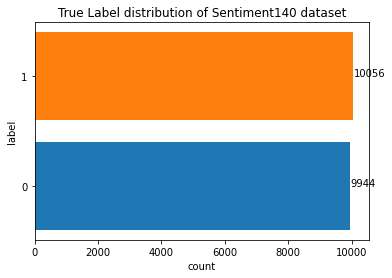

In [16]:
negative = sentiment_train[sentiment_train['label']==0].shape[0]
positive = sentiment_train[sentiment_train['label']==1].shape[0]
x = ["0", "1"]
y = [negative, positive]
plt.title("True Label distribution of Sentiment140 dataset")
plt.ylabel('label')
plt.xlabel('count')
colors = ['tab:blue','tab:orange']
plt.barh(x, y, color = colors)

for index, value in enumerate(y):
    plt.text(value, index, str(value))

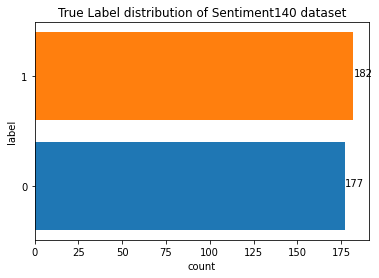

In [17]:
negative = sentiment_test[sentiment_test['label']==0].shape[0]
positive = sentiment_test[sentiment_test['label']==1].shape[0]
x = ["0", "1"]
y = [negative,positive]
plt.title("True Label distribution of Sentiment140 dataset")
plt.ylabel('label')
plt.xlabel('count')
colors = ['tab:blue','tab:orange']
plt.barh(x, y, color = colors)

for index, value in enumerate(y):
    plt.text(value, index, str(value))

In [18]:
# dataset before feature extraction 
sentiment_trainC = sentiment_train.text
sentiment_testC = sentiment_test.text
yTrain_sentimentC = sentiment_train.label
yTest_sentimentC = sentiment_test.label

### **1.4 Extracting Features**

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfid_vect_sentiment = TfidfVectorizer(analyzer = "word", max_features=10000, min_df=3)

yTrain_sentiment = sentiment_train.label
yTest_sentiment = sentiment_test.label

# Vectorize the datasets and use a common vocab to transform the test df
xTrain_sentiment = tfid_vect_sentiment.fit_transform(sentiment_train.text).toarray()

vocab_sentiment = tfid_vect_sentiment.vocabulary_
tfid_vect2_sentiment = TfidfVectorizer(vocabulary=vocab_sentiment)
xTest_sentiment = tfid_vect2_sentiment.fit_transform(sentiment_test.text).toarray()
# print names
print(tfid_vect_sentiment.get_feature_names())
print(tfid_vect2_sentiment.get_feature_names())


['00', '000', '02', '04', '06', '09', '10', '100', '1000', '100th', '10am', '10k', '10pm', '10th', '11', '11am', '12', '13', '14', '140', '14th', '15', '15th', '16', '17', '17th', '18', '182', '18th', '19', '19th', '1st', '20', '200', '2000', '2006', '2007', '2009', '2010', '20th', '21', '21st', '22', '22nd', '23', '24', '24th', '25', '26', '27', '28', '29', '2am', '2day', '2moro', '2morrow', '2moz', '2mrw', '2nd', '2night', '2nite', '2pm', '2x', '30', '300', '30am', '30pm', '30secondstomars', '31', '311', '32', '33', '330', '333', '3333', '34', '35', '350', '360', '37', '3am', '3d', '3g', '3hrs', '3pm', '3rd', '40', '400', '41', '42', '447', '45', '48', '4am', '4got', '4real', '4th', '4ward', '50', '500', '5am', '5pm', '5th', '5yr', '60', '600', '64', '67', '6am', '6pm', '6th', '70', '72', '75', '7am', '7th', '80', '80s', '8am', '8pm', '8th', '90', '90210', '90s', '95', '98', '99', '9am', '9pm', '9th', '__', 'aah', 'aaron', 'abc', 'ability', 'able', 'about', 'above', 'abs', 'absent', 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [20]:
xTrain_sentimentOriginal, yTrain_sentimentOriginal, xTest_sentimentOriginal, yTest_sentimentOriginal = xTrain_sentiment, yTrain_sentiment, xTest_sentiment, yTest_sentiment

In [21]:
from sklearn.calibration import CalibratedClassifierCV
from imblearn.under_sampling import InstanceHardnessThreshold
from sklearn.svm import LinearSVC
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectFromModel

def extract_features(xTrain_sentiment, yTrain_sentiment, xTest_sentiment, yTest_sentiment):
  iht = InstanceHardnessThreshold(random_state=0, n_jobs=11,
                                  estimator=CalibratedClassifierCV(
                                      LinearSVC(C=100, penalty='l1', max_iter=500, dual=False)
                                  ))
  X_resampled, y_resampled = iht.fit_resample(xTrain_sentiment, yTrain_sentiment)
  print(sorted(Counter(y_resampled).items()))


  X, yTrain_sentiment = X_resampled, y_resampled
  X_test, y_test = xTest_sentiment, yTest_sentiment

  scaler = MinMaxScaler()
  X_norm = scaler.fit_transform(X)
  X_test_norm = scaler.transform(X_test)

  xTrain_sentimentOriginal = X_norm
  yTrain_sentimentOriginal = y_resampled
  xTest_sentimentOriginal = X_test_norm
  yTest_sentimentOriginal = sentiment_test.label



  lsvc = LinearSVC(C=100, penalty='l1', max_iter=500, dual=False)
  lsvc.fit(X_resampled, y_resampled)
  fs = SelectFromModel(lsvc, prefit=True)
  X_selected = fs.transform(X_norm)
  X_test_selected = fs.transform(X_test_norm)


  xTrain_sentiment = X_selected
  xTest_sentiment = X_test_selected


  print("New dataset shape: ", xTrain_sentiment.shape)
  print("Original amount of features: ", xTrain_sentimentOriginal.shape[1])
  print("Current amount of features: ", xTrain_sentiment.shape[1])
  print("Features reduscted: ",xTrain_sentimentOriginal.shape[1] - xTrain_sentiment.shape[1])

  return xTrain_sentiment, xTest_sentiment, yTrain_sentiment, yTest_sentiment

In [22]:
xTrain_sentiment, xTest_sentiment, yTrain_sentiment, yTest_sentiment= extract_features(xTrain_sentiment, yTrain_sentiment, xTest_sentiment, yTest_sentiment)

[(0, 9944), (1, 9944)]
New dataset shape:  (19888, 5624)
Original amount of features:  5782
Current amount of features:  5624
Features reduscted:  158


# **2. Implement the Models**



In [ ]:
import numpy as np
import itertools
%matplotlib inline
import matplotlib.pyplot as plt

### **2.1 Naive Bayes Model**




In [ ]:
class MultinomialNB(object):
    # set alpha to be 1 by default
    def __init__(self, alpha):
        self.alpha = alpha

    def fit(self, X, y):
        # count number of data points or samples
        count_sample = X.shape[0]
        # Check each class and count 
        classes = [[x for x, t in zip(X, y) if t == c] for c in np.unique(y)]
        # Calculate the prior
        self.class_log_prior_ = [np.log(len(i) / count_sample) for i in classes]
        # calculate count of each word for each class and add self.alpha as smoothing
        count = np.array([np.array(i).sum(axis=0) for i in classes]) + self.alpha
        # calculate the log probability of each word
        self.feature_log_prob_ = np.log(count / count.sum(axis=1)[np.newaxis].T)
        return self

    def predict_log_proba(self, X):
        return [(self.feature_log_prob_ * x).sum(axis=1) + self.class_log_prior_
                for x in X]

    def predict(self, X):
        # maximize probability
        return np.argmax(self.predict_log_proba(X), axis=1)

In [ ]:
# class GaussianNaiveBayes():
    
#     def __init__(self, alpha):
#       self.alpha = alpha
#       return
    
#     def fit(self, x, y):
#         N, D = x.shape
#         # liyun => change 1 to self.alpha
#         C = np.max(y) + 1
#         # one parameter for each feature conditioned on each class
#         mu, sigma = np.zeros((C,D)), np.zeros((C,D))
#         Nc = np.zeros(C) # number of instances in class c
#         # for each class get the MLE for the mean and std
#         for c in range(C):
#             x_c = x[y == c]                           #slice all the elements from class c
#             Nc[c] = x_c.shape[0]                      #get number of elements of class c
#             mu[c,:] = np.mean(x_c,0)                  #mean of features of class c
#             sigma[c,:] = np.std(x_c, 0)               #std of features of class c
            
#         self.mu = mu                                  # C x D
#         self.sigma = sigma                            # C x D
#         self.pi = (Nc+1)/(N+C)                        #Laplace smoothing (using alpha_c=1 for all c) you can derive using Dirichlet's distribution
#         return self

In [ ]:
# def logsumexp(Z):                                                # dimension C x N
#     Zmax = np.max(Z,axis=0)[None,:]                              # max over C
#     log_sum_exp = Zmax + np.log(np.sum(np.exp(Z - Zmax), axis=0))
#     return log_sum_exp

# def predict(self, xt):
#     Nt, D = xt.shape
#     # for numerical stability we work in the log domain
#     # we add a dimension because this is added to the log-likelihood matrix 
#     # that assigns a likelihood for each class (C) to each test point, and so it is C x N
#     log_prior = np.log(self.pi)[:, None]
#     # logarithm of the likelihood term for Gaussian 
#     # the first two terms are the logarithm of the normalization term in the Gaussian and the final term is the exponent in the Gaussian. 
#     # Notice that we are adding dimensions (using None) to model parameters and data to make this evaluation. 
#     # The reason is that sigma and mu are C x D, while the data x is N x D. We operate on a C x N x D shape by increasing the number of dimensions when needed
#     log_likelihood = -.5 * np.log(2*np.pi) - np.log(self.sigma[:,None,:]) -.5 * (((xt[None,:,:] - self.mu[:,None,:])/self.sigma[:,None,:])**2)
#     # now we sum over the feature dimension to get a C x N matrix (this has the log-likelihood for each class-test point combination)
#     log_likelihood = np.sum(log_likelihood, axis=2)
#     # posterior calculation
#     log_posterior = log_prior + log_likelihood
#     posterior = np.exp(log_posterior - logsumexp(log_posterior))
#     return posterior.T                                                  # dimension N x C

# GaussianNaiveBayes.predict = predict

### **2.2 K-Fold Cross Validation**

In [ ]:
def cross_validate(n, n_folds=10):
    #get the number of data samples in each split
    n_val = n // n_folds
    inds = np.random.permutation(n)
    inds = []
    for f in range(n_folds):
        tr_inds = []
        #get the validation indexes
        val_inds = list(range(f * n_val, (f+1)*n_val))
        #get the train indexes
        if f > 0:
            tr_inds = list(range(f*n_val))
        if f < n_folds - 1:
            tr_inds = tr_inds + list(range((f+1)*n_val, n))
        #The yield statement suspends function’s execution and sends a value back to the caller
        #but retains enough state information to enable function to resume where it is left off
        yield tr_inds, val_inds

# evaluate accuracy
def evaluate_acc(y_pred, y_true):
    # returns the mean accuracy
    count = 0
    for i in range(len(y_pred)):
        if y_pred.tolist()[i] == y_true.tolist()[i]:
            count+=1
    return count/len(y_pred) 

def kfoldCV(x, y, model, n_folds):
  result = 0
  total_x = np.array(x).shape[0]
  for f, (tr, val) in enumerate(cross_validate(total_x, n_folds)):
    x_train = np.array(x)[tr]
    y_train = np.array(y)[tr]
    x_val = np.array(x)[val]
    y_val = np.array(y)[val]
    model = model.fit(x_train, y_train)
    y_pred = model.predict(x_val)
    result += evaluate_acc(y_pred, y_val)
  return result / n_folds
    

### **2.3 Hyper-parameter tuning and model selection**

Best Alpha Value: 0.25
Highest accuracy: 0.5805883832034197


Text(0.5, 1.0, 'Variation of 5 Fold Cross Validation Acc as a Function of Alpha')

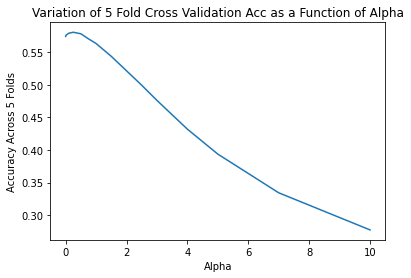

In [ ]:
alpha = np.array([0.001, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1, 1.5, 2.5, 3, 4, 5, 7, 10], dtype=np.float_)
accuracy_list= []
max_acc = 0
best_alpha = 0
for a in alpha:
  model = MultinomialNB(alpha=a)
  acc = kfoldCV(xTrain_sentiment, yTrain_sentiment, model, 5)
  if acc > max_acc:
    max_acc = acc
    best_alpha = a
  accuracy_list.append(acc)
  

# plot the results as 
data = {'alpha': alpha, '5 fold accuracy': accuracy_list}
df = pd.DataFrame(data)
print("Best Alpha Value:", best_alpha)
print("Highest accuracy:", max_acc)
plt.plot(alpha, accuracy_list)
plt.ylabel('Accuracy Across 5 Folds')
plt.xlabel('Alpha')
plt.title("Variation of 5 Fold Cross Validation Acc as a Function of Alpha")

The best alpha value for Multinomial Naive Bayes is **0.25**

This produced a best average prediction accuracy of **52.06%**

In [ ]:
best_model = MultinomialNB(alpha=best_alpha)
best_model.fit(xTrain_sentiment, yTrain_sentiment)
print("Training Accuracy with best model:", evaluate_acc(best_model.predict(xTrain_sentiment),  yTrain_sentiment))

print("Test accuracy with best model:", evaluate_acc(best_model.predict(xTest_sentiment),  yTest_sentiment))

Training Accuracy with best model: 0.8275341914722446
Test accuracy with best model: 0.766016713091922


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs', max_iter=550, n_jobs=-1)
param_grid = {'C': [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1, 2.5, 3, 5, 7, 10, 12, 15, 17, 20, 30, 40, 50, 60, 65, 70, 75, 80, 90, 100]}
grid = GridSearchCV(model, param_grid, cv=5)
grid.fit(xTrain_sentiment, yTrain_sentiment)

print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)
print(grid.best_estimator_)

The best c value for Logistic Regression is **0.5**

This produced a best prediction accuracy of **76.0%**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
def compare_c_acc(x_train, y_train, x_test, y_test, model):
  acc_list = []
  c_list = [0.01, 0.05, 0.1, 0.25, 0.5, 0.6, 0.7, 0.75, 0.8, 0.9, 1, 2.5, 3, 5, 7, 10, 12, 15, 100]

  part_x_train, _, part_y_train, _ = \
      train_test_split(
          x_train,
          y_train,
          train_size=0.8,
          random_state=42,
          shuffle=True
        )
 
  for c in c_list:
    model.C = c
    model.fit(part_x_train, part_y_train)

    y_pred = model.predict(x_test)
    acc = evaluate_acc(y_pred, y_test)
    acc_list.append(acc)

    

  best_acc = max(acc_list)
  idx = acc_list.index(best_acc)

  return c_list, acc_list

lr_model_c_acc = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs', max_iter=550, n_jobs=-1)
c_list_lr, acc_list_lr = compare_c_acc(xTrain_sentiment, yTrain_sentiment, xTest_sentiment, yTest_sentiment, lr_model_c_acc)

# **3. Run Experiments**

### **3.1 Performing Naive Bayes and Logistic Regression classification**

**Define best hyperparameters** 

In [24]:
best_alpha = 0.25
print(best_alpha)
best_C = 0.5
print(best_C)

0.25
0.5


####**3.1.1 Naive Bayes**

In [ ]:
best_modelNB = MultinomialNB(alpha=best_alpha)
# looking for training accuracy 
best_modelNB.fit(xTrain_sentiment, yTrain_sentiment)
trainingAcc_NB = evaluate_acc(best_modelNB.predict(xTrain_sentiment),  yTrain_sentiment)
print("Training Accuracy with best NB model:", trainingAcc_NB)
testingAcc_NB = evaluate_acc(best_modelNB.predict(xTest_sentiment), yTest_sentiment)
print("Test Accuracy with best NB model:", testingAcc_NB)

Training Accuracy with best NB model: 0.8275341914722446
Test Accuracy with best NB model: 0.766016713091922


#### **3.1.2 Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression
best_modelLG = LogisticRegression(C=0.5, max_iter=550, multi_class='multinomial', n_jobs=-1)
best_modelLG.fit(xTrain_sentiment, yTrain_sentiment)
trainingAcc_LG = evaluate_acc(best_modelLG.predict(xTrain_sentiment),  yTrain_sentiment)
print("Training Accuracy with best LR model:", trainingAcc_LG)
testingAcc_LG = evaluate_acc(best_modelLG.predict(xTest_sentiment), yTest_sentiment)
print("Test accuracy with best LR model:", testingAcc_LG)

Training Accuracy with best LR model: 0.851015687851971
Test accuracy with best LR model: 0.766016713091922


### **3.2 Compare performance of models**

In [ ]:
from prettytable import PrettyTable
resultTable = PrettyTable()
resultTable.title = "Best performance of MultinomialNB and Logistic Regression on both testing datasets"
resultTable.field_names = [" ", "Sentiment"]


resultTable.add_row(['MultinomialNB - Training Accuracy', trainingAcc_NB])
resultTable.add_row(['MultinomialNB - Testing Accuracy', testingAcc_NB])
resultTable.add_row(['Logistic Regression - Training Accuracy', trainingAcc_LG])
resultTable.add_row(['Logistic Regression - Testing Accuracy', testingAcc_LG])
print(resultTable)

+------------------------------------------------------------------------------------+
| Best performance of MultinomialNB and Logistic Regression on both testing datasets |
+--------------------------------------------------------+---------------------------+
|                                                        |         Sentiment         |
+--------------------------------------------------------+---------------------------+
|           MultinomialNB - Training Accuracy            |     0.8275341914722446    |
|            MultinomialNB - Testing Accuracy            |     0.766016713091922     |
|        Logistic Regression - Training Accuracy         |     0.851015687851971     |
|         Logistic Regression - Testing Accuracy         |     0.766016713091922     |
+--------------------------------------------------------+---------------------------+


### **3.3 Comparing accuracy as function of dataset size**

#### **3.3.1 Naive Bayes**

In [ ]:
from sklearn.model_selection import train_test_split


def compare_naive_bayes_acc(x_train, y_train, x_test, y_test):
  training_size_list = [0.2, 0.4, 0.6, 0.8]
  acc_list = []
 
  for training_size in training_size_list:
    part_x_train, _, part_y_train, _ = \
      train_test_split(
          x_train,
          y_train,
          train_size=training_size,
          random_state=42,
          shuffle=True
        )
    
    model = MultinomialNB(alpha=best_alpha)
    model.fit(part_x_train, part_y_train)

    y_pred = model.predict(x_test)
    acc = evaluate_acc(y_pred, y_test)
    acc_list.append(acc)
    print("Acc with training_size (%s) = %s\n" % (training_size, acc))
  training_size_list.append(1.0)
  model = MultinomialNB(best_alpha)
  model.fit(x_train, y_train)
  y_pred = model.predict(x_test)
  acc = evaluate_acc(y_pred, y_test)
  acc_list.append(acc)
  print("Acc with training_size (%s) = %s\n" % (1, acc))
  best_acc  = max(acc_list)
  idx = acc_list.index(best_acc)

  print("Best accuracy training_size with %s = %s\n" % (training_size_list[idx], best_acc))
  return acc_list

In [ ]:
NB_accList_test1 = compare_naive_bayes_acc(xTrain_sentiment, yTrain_sentiment, xTest_sentiment, yTest_sentiment)

Acc with training_size (0.2) = 0.7437325905292479

Acc with training_size (0.4) = 0.7493036211699164

Acc with training_size (0.6) = 0.7381615598885793

Acc with training_size (0.8) = 0.7938718662952646

Acc with training_size (1) = 0.766016713091922

Best accuracy training_size with 0.8 = 0.7938718662952646



Acc with training_size (0.2) = 0.7520891364902507

Acc with training_size (0.4) = 0.766016713091922

Acc with training_size (0.6) = 0.7771587743732591

Acc with training_size (0.8) = 0.7743732590529248

Acc with training_size (1) = 0.7688022284122563

Best accuracy training_size with 0.6 = 0.7771587743732591



<Figure size 432x288 with 0 Axes>

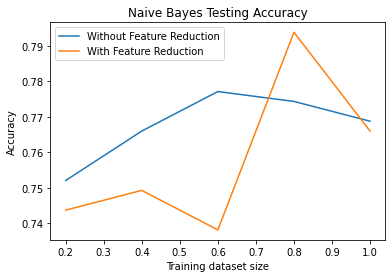

<Figure size 432x288 with 0 Axes>

In [ ]:

NB_accList_test2 = compare_naive_bayes_acc(xTrain_sentimentOriginal, yTrain_sentimentOriginal, xTest_sentimentOriginal, yTest_sentimentOriginal)
training_size_list = [0.2, 0.4, 0.6, 0.8, 1.0]
# plot 
plt.plot(training_size_list, NB_accList_test2, label ="Without Feature Reduction")
plt.plot(training_size_list, NB_accList_test1, label ="With Feature Reduction")
plt.xlabel('Training dataset size')
plt.ylabel('Accuracy')
plt.title("Naive Bayes Testing Accuracy")
plt.legend()
plt.figure()


####**3.3.2 Logistic Regression**

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.exceptions import ConvergenceWarning
from sklearn.feature_extraction.text import CountVectorizer
import warnings
from prettytable import PrettyTable

warnings.simplefilter("ignore", category=ConvergenceWarning)

In [28]:

def compare_log_reg_acc(x_train, y_train, x_test, y_test):
  acc_list = []
  training_size_list = [0.2, 0.4, 0.6, 0.8]
  for training_size in training_size_list:
    # Use percentage of training and testing data
    part_x_train, _, part_y_train, _ = \
      train_test_split(
          x_train,
          y_train,
          train_size=training_size,
          random_state=42,
          shuffle=True
        )


    lr = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs', C=best_C, max_iter=550, n_jobs=-1)
    lr.fit(part_x_train, part_y_train)
    y_hat = lr.predict(x_test)

    acc = accuracy_score(y_test, y_hat)
    print("Testing accuracy training_size %s = %s\n" % (training_size, acc))
    acc_list.append(acc)
  training_size_list.append(1.0)
  model = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs', C=best_C, max_iter=550, n_jobs=-1)
  model.fit(x_train, y_train)
  y_pred = model.predict(x_test)
  acc = accuracy_score(y_pred, y_test)
  acc_list.append(acc)
  print("Acc with training_size (%s) = %s\n" % (1, acc))
  best_acc  = max(acc_list)
  idx = acc_list.index(best_acc)

  

  print("Best testing accuracy training_size with %s = %s\n" % (training_size_list[idx], best_acc))
  return acc_list

   

In [29]:
LR_accList_test1 = compare_log_reg_acc(xTrain_sentiment, yTrain_sentiment, xTest_sentiment, yTest_sentiment)
# plot 


Testing accuracy training_size 0.2 = 0.7047353760445683

Testing accuracy training_size 0.4 = 0.7520891364902507

Testing accuracy training_size 0.6 = 0.7799442896935933

Testing accuracy training_size 0.8 = 0.7743732590529248

Acc with training_size (1) = 0.766016713091922

Best testing accuracy training_size with 0.6 = 0.7799442896935933



In [30]:
LR_accList_test2 = compare_log_reg_acc(xTrain_sentimentOriginal, yTrain_sentimentOriginal, xTest_sentimentOriginal, yTest_sentimentOriginal)


Testing accuracy training_size 0.2 = 0.7298050139275766

Testing accuracy training_size 0.4 = 0.7270194986072424

Testing accuracy training_size 0.6 = 0.7493036211699164

Testing accuracy training_size 0.8 = 0.7493036211699164

Acc with training_size (1) = 0.754874651810585

Best testing accuracy training_size with 1.0 = 0.754874651810585



<Figure size 432x288 with 0 Axes>

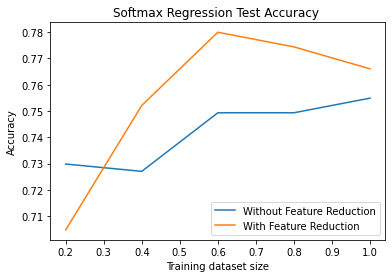

<Figure size 432x288 with 0 Axes>

In [31]:

# plot 
training_size_list = [0.2, 0.4, 0.6, 0.8, 1.0]
plt.plot(training_size_list, LR_accList_test2, label ="Without Feature Reduction")
plt.plot(training_size_list, LR_accList_test1, label ="With Feature Reduction")
plt.xlabel('Training dataset size')
plt.ylabel('Accuracy')
plt.title("Softmax Regression Test Accuracy ")
plt.legend()
plt.figure()

#### **3.3.3 Summary**

In [ ]:
from prettytable import PrettyTable
resultTable = PrettyTable()
resultTable.title = "Performance of NB and LR models as functions of dataset size"
resultTable.field_names = [" ", "Dataset Size", "Test Accuracy With Feature Reduction", "Test Accuracy Without Feature Reduction"]

for i, (NB_FS, NB_WFS) in enumerate(zip(NB_accList_test1, NB_accList_test2)):
  resultTable.add_row(['Multinomial Naive Bayes', training_size_list[i], "{:.2f}%".format(NB_FS*100), "{:.2f}%".format(NB_WFS*100)])

resultTable.add_row(['', '', '', ''])

for i, (LR_FS, LR_WFS) in enumerate(zip(LR_accList_test1, LR_accList_test2)):
  resultTable.add_row(['Logistic Regression', training_size_list[i], "{:.2f}%".format(LR_FS*100), "{:.2f}%".format(LR_WFS*100)])

print(resultTable)

### **3.4 Creative Experiment**

####**3.4.1 Count Vectorizer vs TF-IDF Vectorizer**

In [ ]:
# dataset before feature extraction 
sentiment_trainC = sentiment_train.text
sentiment_testC = sentiment_test.text
yTrain_sentimentC = sentiment_train.label
yTest_sentimentC = sentiment_test.label

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfid_vect_sentiment = TfidfVectorizer(analyzer = "word", max_features=10000, min_df=3)
xTrain_sentiment = tfid_vect_sentiment.fit_transform(sentiment_trainC).toarray()

vocab_sentiment = tfid_vect_sentiment.vocabulary_
tfid_vect2_sentiment = TfidfVectorizer(vocabulary=vocab_sentiment)
xTest_sentiment = tfid_vect2_sentiment.fit_transform(sentiment_testC).toarray()

yTrain_sentiment = yTrain_sentimentC 
yTest_sentiment = yTest_sentimentC
xTrain_sentiment, xTest_sentiment, yTrain_sentiment, yTest_sentiment= extract_features(xTrain_sentiment, yTrain_sentiment, xTest_sentiment, yTest_sentiment)
nbmodel2 = MultinomialNB(alpha=best_alpha)
lrmodel2 = LogisticRegression(C=0.5, max_iter=550, multi_class='multinomial', n_jobs=-1)

lrmodel2.fit(xTrain_sentiment, yTrain_sentiment)
acc2 = evaluate_acc(lrmodel2.predict(xTrain_sentiment),  yTrain_sentiment)
acc2test = evaluate_acc(lrmodel2.predict(xTest_sentiment),  yTest_sentiment)

nbmodel2.fit(xTrain_sentiment,  yTrain_sentiment)
acc3 = evaluate_acc(nbmodel2.predict(xTrain_sentiment),  yTrain_sentiment)
acc3test = evaluate_acc(nbmodel2.predict(xTest_sentiment),  yTest_sentiment)

print()
print('Training accuracy LR with TF-IDF = ', acc2)
print('Test accuracy LR with TF-IDF = ', acc2test)
print('Traing NB with TF-IDF = ', acc3)
print('Test accuracy NB with TF-IDF = ', acc3test)

[(0, 9944), (1, 9944)]
New dataset shape:  (19888, 5621)
Original amount of features:  5782
Current amount of features:  5621
Features reduscted:  161

Training accuracy LR with TF-IDF =  0.8510659694288013
Test accuracy LR with TF-IDF =  0.766016713091922
Traing NB with TF-IDF =  0.827433628318584
Test accuracy NB with TF-IDF =  0.766016713091922


In [ ]:
cv = CountVectorizer(min_df = 3)
cv.fit(sentiment_trainC)
cv_sentiment_train_data = cv.transform(sentiment_trainC).toarray()
cv_sentiment_test_data = cv.transform(sentiment_testC).toarray()
xTrain_sentiment, xTest_sentiment, yTrain_sentiment, yTest_sentiment = extract_features(cv_sentiment_train_data, yTrain_sentimentC, cv_sentiment_test_data, yTest_sentimentC)
nbmodel3 = MultinomialNB(alpha=best_alpha)
lrmodel3 = LogisticRegression(C=0.5, max_iter=550, multi_class='multinomial', n_jobs=-1)

lrmodel3.fit(xTrain_sentiment,  yTrain_sentiment)
acc3=evaluate_acc(lrmodel3.predict(xTrain_sentiment),  yTrain_sentiment)
acc3test = evaluate_acc(lrmodel3.predict(xTest_sentiment),  yTest_sentiment)

nbmodel3.fit(xTrain_sentiment,  yTrain_sentiment)
acc4 = evaluate_acc(nbmodel3.predict(xTrain_sentiment),  yTrain_sentiment)
acc4test = evaluate_acc(nbmodel3.predict(xTest_sentiment),  yTest_sentiment)

print()
print('Training accuracy LR with Count = ', acc3)
print('Test accuracy LR with Count = ', acc3test)
print('Traing NB with Count = ', acc4)
print('Test accuracy NB with Count = ', acc4test)

[(0, 9944), (1, 9944)]
New dataset shape:  (19888, 5542)
Original amount of features:  5782
Current amount of features:  5542
Features reduscted:  240

Training accuracy LR with Count =  0.8533286403861625
Test accuracy LR with Count =  0.7743732590529248
Traing NB with Count =  0.8188857602574416
Test accuracy NB with Count =  0.7688022284122563


####**3.4.2 The effect of min_df on accuracy**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
def n_grams(train, test):

  nbTrain = []
  nbTest = []

  logTrain = []
  logTest = []

  df = [1, 2, 3, 4, 5, 6, 7]

  for num in df:
    tfid_vect_sentiment = TfidfVectorizer(analyzer = "word", max_features=10000, min_df=num)
    xTrain_sentiment = tfid_vect_sentiment.fit_transform(train).toarray()

    vocab_sentiment = tfid_vect_sentiment.vocabulary_
    tfid_vect2_sentiment = TfidfVectorizer(vocabulary=vocab_sentiment)
    xTest_sentiment = tfid_vect2_sentiment.fit_transform(test).toarray()

    yTrain_sentiment = sentiment_train.label
    yTest_sentiment = sentiment_test.label
    xTrain_sentiment, xTest_sentiment, yTrain_sentiment, yTest_sentiment= extract_features(xTrain_sentiment, yTrain_sentiment, xTest_sentiment, yTest_sentiment)
    nbmodel2 = MultinomialNB(alpha=best_alpha)
    lrmodel2 = LogisticRegression(C=0.5, max_iter=550, multi_class='multinomial', n_jobs=-1)

    lrmodel2.fit(xTrain_sentiment, yTrain_sentiment)
    acc2 = evaluate_acc(lrmodel2.predict(xTrain_sentiment),  yTrain_sentiment)
    logTrain.append(acc2)
    acc2test = evaluate_acc(lrmodel2.predict(xTest_sentiment),  yTest_sentiment)
    logTest.append(acc2test)

    nbmodel2.fit(xTrain_sentiment,  yTrain_sentiment)
    acc3 = evaluate_acc(nbmodel2.predict(xTrain_sentiment),  yTrain_sentiment)
    nbTrain.append(acc3)
    acc3test = evaluate_acc(nbmodel2.predict(xTest_sentiment),  yTest_sentiment)
    nbTest.append(acc3test)

    print()
    print('min_df = ', num)
    print('Training accuracy LR with TF-IDF = ', acc2)
    print('Test accuracy LR with TF-IDF = ', acc2test)
    print('Traing NB with TF-IDF = ', acc3)
    print('Test accuracy NB with TF-IDF = ', acc3test)
    print()

  print("----------Naive Bayes-----------")
  plt.plot(df, nbTrain , '-', label='train NB')
  plt.plot(df, nbTest , '-', label='test NB')
  plt.plot(df, logTrain , '-', label='train LR')
  plt.plot(df, logTest , '-', label='test LR')
  plt.legend()
  plt.xlabel('n-grams number')
  plt.ylabel('accuracy')
  plt.show() 

[(0, 9944), (1, 9944)]
New dataset shape:  (19888, 7729)
Original amount of features:  10000
Current amount of features:  7729
Features reduscted:  2271

min_df =  1
Training accuracy LR with TF-IDF =  0.8726870474658085
Test accuracy LR with TF-IDF =  0.7604456824512534
Traing NB with TF-IDF =  0.8622787610619469
Test accuracy NB with TF-IDF =  0.7855153203342619

[(0, 9944), (1, 9944)]
New dataset shape:  (19888, 7367)
Original amount of features:  8811
Current amount of features:  7367
Features reduscted:  1444

min_df =  2
Training accuracy LR with TF-IDF =  0.8682119871279164
Test accuracy LR with TF-IDF =  0.7576601671309192
Traing NB with TF-IDF =  0.8544851166532582
Test accuracy NB with TF-IDF =  0.7799442896935933

[(0, 9944), (1, 9944)]
New dataset shape:  (19888, 5622)
Original amount of features:  5782
Current amount of features:  5622
Features reduscted:  160

min_df =  3
Training accuracy LR with TF-IDF =  0.8511665325824618
Test accuracy LR with TF-IDF =  0.766016713091

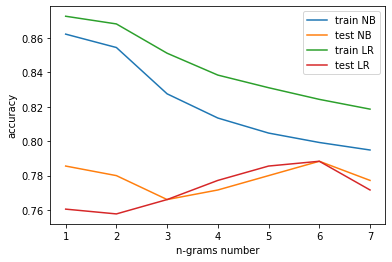

In [ ]:
train = sentiment_trainC
test = sentiment_testC
n_grams(train, test)

####**3.4.3 SVM**

In [ ]:
gs_SVM_linear = SVC(kernel='linear')
gridSearch_cross_validation(gs_SVM_linear, xTrain_sentiment, yTrain_sentiment)

The best c value for Linear SVM is **1.0**

This produced a best prediction accuracy of **70.0%**

In [ ]:
from sklearn.svm import SVC

svclassifier = SVC(kernel='linear', C=1)
svclassifier.fit(xTrain_sentiment, yTrain_sentiment)
y_pred = svclassifier.predict(xTest_sentiment)
acc1 = evaluate_acc(y_pred,  yTest_sentiment)
print(acc1)
c_list_svm_linear, acc_list_svm_linear = compare_c_acc(xTrain_sentiment, yTrain_sentiment, xTest_sentiment, yTest_sentiment, svclassifier)

In [ ]:
gs_SVM_poly = SVC(kernel='poly')
gridSearch_cross_validation(gs_SVM_poly, xTrain_sentiment, yTrain_sentiment)

The best c value for Poly SVM is **10.0**

This produced a best prediction accuracy of **63.0%**

In [ ]:
svclassifier = SVC(kernel='poly', C=10)
svclassifier.fit(xTrain_sentiment, yTrain_sentiment)
y_pred = svclassifier.predict(xTest_sentiment)
acc2 = evaluate_acc(y_pred,  yTest_sentiment)
print(acc2)
c_list_svm_poly, acc_list_svm_poly = compare_c_acc(xTrain_sentiment, yTrain_sentiment, xTest_sentiment, yTest_sentiment, svclassifier)

In [ ]:
gs_SVM_rbf = SVC(kernel='rbf')
gridSearch_cross_validation(gs_SVM_rbf, xTrain_sentiment, yTrain_sentiment)

The best c value for Linear SVM is **5**

This produced a best prediction accuracy of **70.0%**

In [ ]:
svclassifier = SVC(kernel='rbf', C=5)
svclassifier.fit(xTrain_sentiment, yTrain_sentiment)
y_pred = svclassifier.predict(xTest_sentiment)
acc3 = evaluate_acc(y_pred,  yTest_sentiment)
print(acc3)
c_list_svm_rbf, acc_list_svm_rbf = compare_c_acc(xTrain_sentiment, yTrain_sentiment, xTest_sentiment, yTest_sentiment, svclassifier)

In [ ]:
plt.plot(c_list_lr, acc_list_lr, label ="Testing accuracy Logistic Regression")
plt.plot(c_list_svm_linear, acc_list_svm_linear, label ="Testing accuracy SVM linear")
plt.plot(c_list_svm_poly, acc_list_svm_poly, label ="Testing accuracy SVM Poly")
plt.plot(c_list_svm_rbf, acc_list_svm_rbf, label ="Testing accuracy SVM rbf")

plt.xlabel('C Value')
plt.ylabel('Accuracy')
plt.title("Accuracy vs. C Value")
plt.legend()
plt.figure()